# Grover's Algorithm with hierarcqal


In [9]:
#!pip install qiskit-aer

In [10]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from hierarqcal import Qinit, Qmask, Qunitary, Qpivot, Qcycle, Qunmask

mpl_backend = mpl.get_backend()

## Background


Grover's algorithm provides an optimal method to amplify the amplitude of a specific state using an oracle. This specific state is usually referred to as the *target state* which we label  $T$. The oracle is a "black-box" with the ability to change the sign of amplitude of the target state, in other words add a $\pi$ phase to the amplitude of the target state. This processes is commonly described as *marking* the target. 

Grover's algorithm works in two steps:

Step 1: Apply the oracle. 

Step 2: Reflect in a plane orthogonal to some state $\psi$. 

It turns out that step 1 and 2 are in fact the same operation, namely a reflection. **Step 1 is in fact a reflection in the plane orthogonal to the target state $T$.**

Reflecting a vector is nothing other than changing the sign of the component of the vector parallel to the vector normal to the plane of reflection, while doing nothing to all other components of the vector:
$$U_{\text{reflection}} = \mathbb{I} - 2|\hat{n}  \rangle\langle \hat{n} |$$
where $\hat{n}$ is the normal vector to the plane of reflection.

We shall see that the algorithm performs optimally if $\psi$,  $T$ and the initial state of the system all lie in the same plane.


Given that we started in some state $\phi$, which we denote in Dirac notation as $|\phi\rangle$

Applying the oracle we have
$$|\phi\rangle \rightarrow (\mathbb{I} - 2|T \rangle\langle T|)|\phi\rangle$$
Followed by a reflection about $\psi$
$$(\mathbb{I} - 2|T \rangle\langle T|)|\phi\rangle \rightarrow (\mathbb{I} - 2|\psi \rangle\langle \psi|)(\mathbb{I} - 2|T \rangle\langle T|)|\phi\rangle$$

One can visualize this process by first noticing that $|\phi\rangle$ can be separated into two components: A component lying in the plane spanned by $|T\rangle$ and $|\psi\rangle$ and a component orthogonal to this plane. In this way we can visualize the process in three dimensions, despite the fact that the process occurs in a high dimensional space.

### Choose the number of qubits and the number of iterations

In [11]:
n = 4
N_iterations = 1 
N_optimal = int((np.pi / 2 / np.arctan(1 / np.sqrt(2**n)) - 1) / 2)
# N_iterations = N_optimal

In [12]:
random_int = np.random.randint(0, 2**n)
Target_string = bin(random_int)[2:].zfill(n)

In [13]:
print("Number of qubits", n)
print("Number of ancillas", n - 3)
print("Total number of qubits", 2 * (n) - 3)
print("Search space size", 2**n)
print("With target", Target_string)

print("\nInteractions of Grover to perform", N_iterations)
print(
    "Optimal number of iterations",
    N_optimal,
)


Number of qubits 4
Number of ancillas 1
Total number of qubits 5
Search space size 16
With target 0001

Interactions of Grover to perform 1
Optimal number of iterations 2


## Create the primitive circuit with Qpivot

In [14]:
# Hadamard
H = Qunitary("H()^0")
# Pauli X
X = Qunitary("X()^0")

# Unitary to prepare the initial state |psi>
U_psi = Qcycle(mapping=H)
# Unitary to prepare the target state |T>
U_T = Qpivot(mapping=X, global_pattern=Target_string[::-1])

# Toffoli gate
U_toffoli = Qinit(3)
U_toffoli += Qpivot(mapping=H, global_pattern="*1")
U_toffoli += Qpivot(mapping=Qunitary("cp(x)^01", symbols=[np.pi / 2]), global_pattern="*1", merge_within="*1")
U_toffoli += Qpivot(mapping=Qunitary("cnot()^01;cp(x)^12;cnot()^01", symbols=[-np.pi / 2]), global_pattern="*1", merge_within="*1")
U_toffoli += Qpivot(mapping=H, global_pattern="*1")

# Mask ancillary qubits
ancilla_str = "0" + "01" * (n - 3) + "00"
maskAncillas = Qmask(ancilla_str)

# Multicontrolled Z gate
multiCZ = Qpivot(mapping=H, global_pattern="*1") 
multiCZ += Qunmask("previous")
multiCZ += Qcycle(mapping=U_toffoli, step=2, boundary="open")
multiCZ += Qmask("*1")
multiCZ += Qcycle(mapping=U_toffoli, step=2, boundary="open", edge_order=[-1])
multiCZ += Qunmask("previous")
multiCZ += maskAncillas 
multiCZ += Qpivot(mapping=H, global_pattern="*1")

# Reflections in the plane orthogonal to |0>: I - 2|0><0|
U_reflect_0 = Qcycle(mapping=X) + multiCZ + Qcycle(mapping=X)

# Oracle
U_oracle = U_T + U_reflect_0 + U_T
# Defusion operator (reflection in the plane orthogonal to |psi>)
U_defuse = U_psi + U_reflect_0 + U_psi

# Name qubits to distinguish between ancillary and query qubits
q_names = [f"q_{i}" if ancilla_str[i] == "0" else f"a_{i}" for i in range(2 * n - 3)]

# Initialise the circuit and prepare the initial state |psi>
Grover = Qinit(q_names) + maskAncillas + U_psi

# Apply the oracle and the defusion operator N_iterations times
if N_iterations > 0:
    Grover += (U_oracle + U_defuse) * N_iterations


In [15]:
# Create the circuit using the chose backend and measure all qubits
circuit = Grover(backend="qiskit", barriers=True)
circuit.measure_all()

## Visualize the primitive circuit

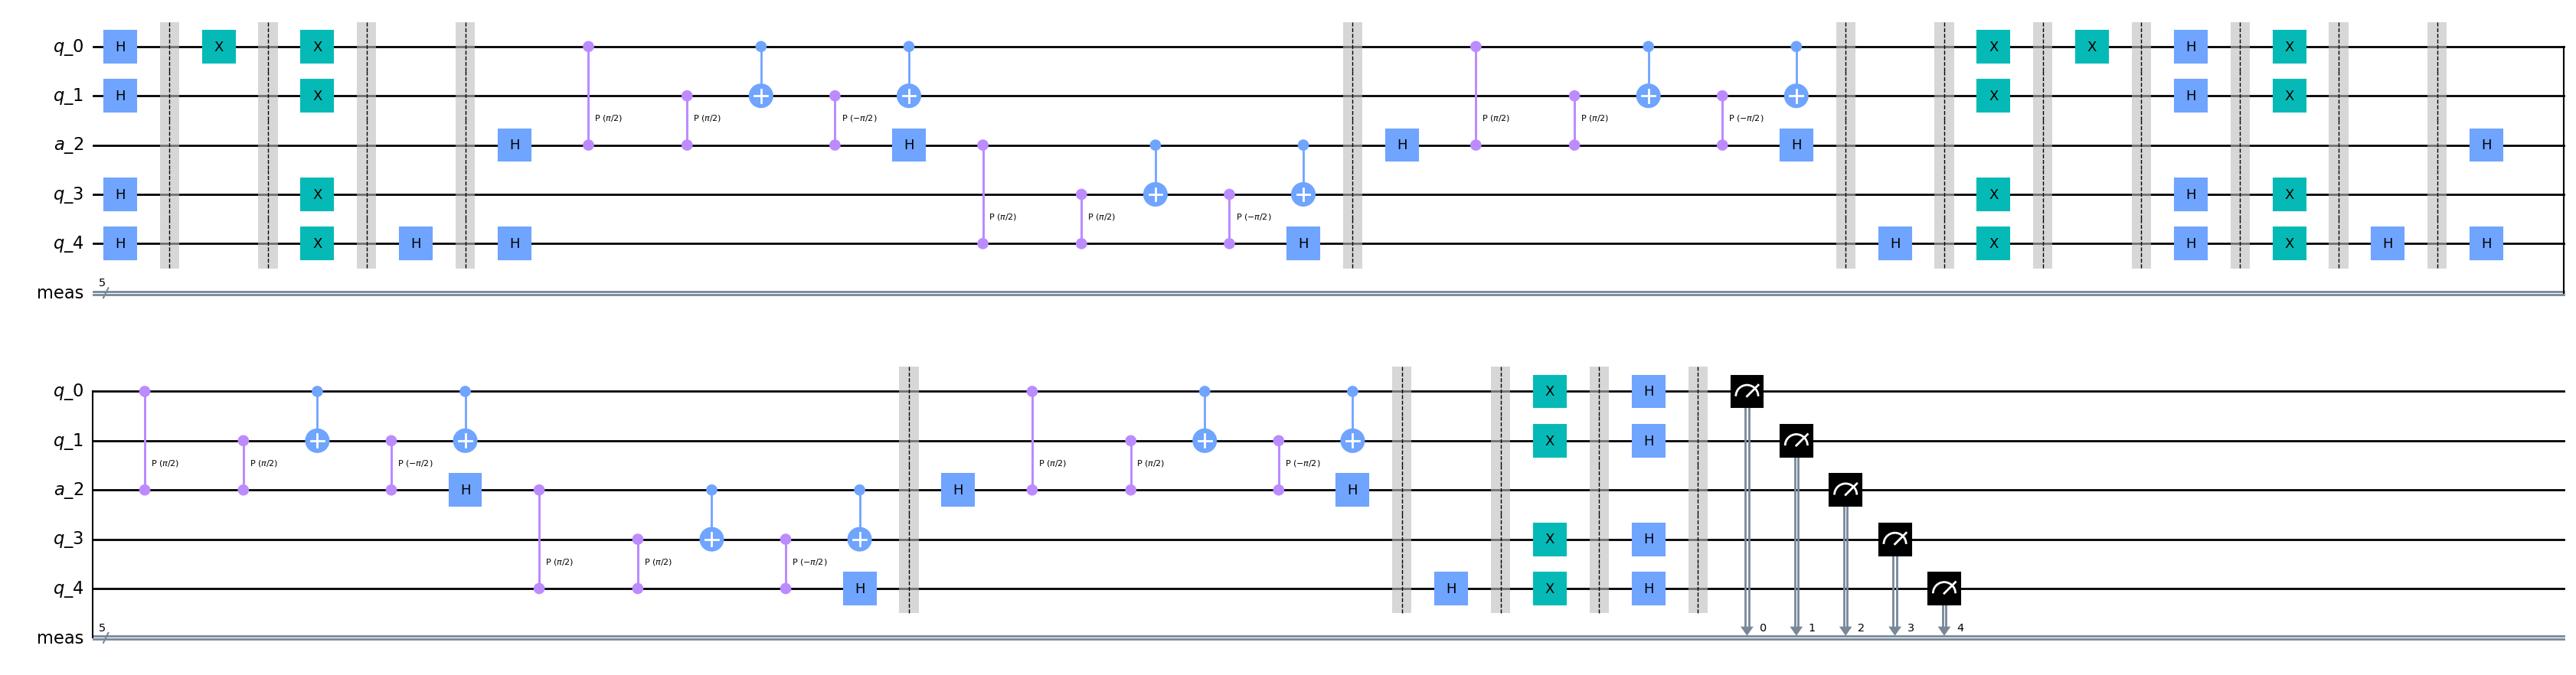

In [16]:
if N_iterations < 4:
    fig = circuit.draw("mpl", fold=50)
else:
    fig = None

fig

In [17]:
# Run the circuit, get counts
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend("qasm_simulator")
job = execute(circuit, backend, shots=100)
result = job.result()
counts = result.get_counts()

In [18]:
Q = []
mask = ["q" if n.split("_")[0] == "q" else "a" for n in q_names]
for k in counts.keys():
    Q.append("".join([k[i] if mask[i] == "q" else "*" for i in range(len(k))]))


In [19]:
counts_q = {}
count_keys = counts.keys()
for x in Q:
    # all binary strings of length n_a
    n_a = len(x.split("*")) - 1
    A = [[x for x in bin(i)[2:].zfill(n_a)] + [""] for i in range(2**n_a)]
    Trace_A = []
    for a in A:
        Trace_A.append("".join([x + y for x, y in zip(x.split("*"), a)]))

    counts_q[x.replace("*", "")] = sum([counts[k] for k in Trace_A if k in count_keys])


Number of qubits 4
Number of ancillas 1
Total number of qubits 5
Search space size 16
With target 0001

Interactions of Grover performed: 1
Optimal number of iterations: 2

State associate with the 5 largest number of count
['0001', '1101', '1100', '0101', '0111']
Number of counts
[52, 5, 5, 5, 4]


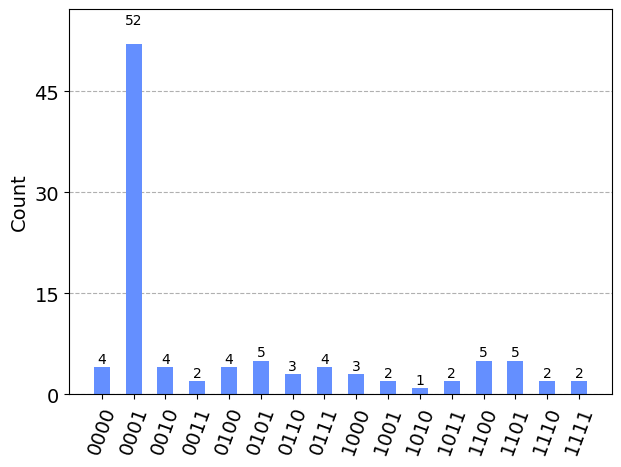

In [20]:
print("Number of qubits", n)
print("Number of ancillas", 2 * (n) - 3 - n)
print("Total number of qubits", 2 * (n) - 3)
print("Search space size", 2**n)
print("With target", Target_string)

print("\nInteractions of Grover performed:", N_iterations)
print("Optimal number of iterations:", int((np.pi / 2 * np.sqrt(2**n) - 1) / 2))
print()

x = counts_q.keys()
y = counts_q.values()
# States associate with the 5 largest value of y
top_x = [x for _, x in sorted(zip(y, x), reverse=True)][:5]
top_y = sorted(y, reverse=True)[:5]

print("State associate with the 5 largest number of count")
print(top_x)
print("Number of counts")
print(top_y)

plot_histogram(counts_q)
